# Exploration de données brutes RNA-Seq

## Quelques rappels

### RNA-Seq

Le RNA-Seq (séquençage de l'ARN), également appelé séquençage aléatoire du transcriptome entier, est une technologie qui utilise le séquençage à haut débit pour identifier et quantifier les produits de transcription d'un génome à un moment donné.

On part du principe que le nombre de fragments d'ARN séquencés est proportionnel à l'abondance des ARNs correspondants dans la cellule et qu'il est donc possible d'en estimer cette abondance. L'objectif est généralement d'étudier les différences d'expression des transcrits entre des échantillons en se basant sur ces estimations d'abondances d'ARN.

La technologie du RNA-Seq peut également permettre de déterminer les positions de départ et de fin de transcription, tous règnes confondus, ainsi que les jonctions entre les exons et les introns chez les eucaryotes.

La méthode la plus simple pour estimer l'abondance des transcrits est d'utiliser une annotation de référence, généralement celle des gènes, et de compter le nombre de produits de séquençage alignés entre les bornes des annotations.

### Grandes étapes

* préparation (récupération de la séquence génomique de l'espèce concernée)
* contrôle qualité (FastQC)
* alignement (de chaque *read* sur le génome de référence)
* comptage

### Comptage

Sous l'hypothèse que le nombre de *reads* venant d'un certain gène est proportionnel à l'abondance de son ARN dans la cellule, on veut compter les *reads* venant de chaque gène, transcrit ou exon du génome.

Cf. https://bioinfo-fr.net/lanalyse-de-donnees-rna-seq-mode-demploi#comptage.

## Objectif

A partir de données de comptage obtenues avec l'outil [HTSeqCount](https://htseq.readthedocs.io/en/release_0.11.1/count.html),

* regrouper les comptages des lectures (*reads*) afin de créer une matrice de comptage de l'ensemble des locus pour toutes les conditions (au format tabulé)
* afficher la profondeur (nombre de *reads*) pour chaque condition
* ordonner la matrice par nom de gènes et de conditions, et filtrer les gènes dont le comptage moyen est inférieur à 5

### Données initiales

Pour comparer les conditions entre elles, il est nécessaire de mesurer les abondances de transcrits de plusieurs échantillons biologiques différents dans chaque condition afin d'étendre les observations à la population pour en généraliser les conclusions (trois répétitions biologiques sont généralement utilisées par condition à comparer en RNA-Seq).

Données de comptage par gène pour chaque échantillon (issues de [HTSeqCount](https://htseq.readthedocs.io/en/release_0.11.1/count.html)) —> 3 mutants et 1 sauvage, 3 réplicats —> 12 fichiers :

In [2]:
!ls ../data/htseqcount    # Commande uniquement valable dans un environnement Unix

Mutant-A_1.htc Mutant-B_1.htc Mutant-C_1.htc Wild_1.htc
Mutant-A_2.htc Mutant-B_2.htc Mutant-C_2.htc Wild_2.htc
Mutant-A_3.htc Mutant-B_3.htc Mutant-C_3.htc Wild_3.htc


Ces fichiers contiennent deux colonnes du type :

```
LOCUS_0476 1199
LOCUS_1221 1266
LOCUS_0644 1727
LOCUS_0590 9514
LOCUS_2883 8391
[…]
```

### Sorties attendues

Deux fichiers au format tabulé contenant une matrice ordonnée par nom de gènes et de conditions dont les comptages moyens sont :

* inférieurs à 5
* supérieurs ou égaux à 5

**Exemple :**

```
Locus Mutant-A_1 Mutant-A_2 Mutant-A_3 Mutant-B_1 Mutant-B_2 Mutant-B_3 Mutant-C_1 Mutant-C_2 Mutant-C_3 Wild_1 Wild_2 Wild_3
LOCUS_0001 408 467 398 701 452 453 501 610 672 634 628 544
LOCUS_0002 9052 9047 8853 8844 9037 8949 8989 8928 8845 2441 2550 2460
[…]
```

### Un petit plus...

On peut explorer les données en regardant la distribution de celles-ci entre réplication avec des *scatterplots*.

## Import des librairies

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

## Gestion des fichiers d'entrée

In [5]:
dir = '../data/htseqcount/'
files = os.listdir(dir)
files.sort()

## Création du Dataframe

In [6]:
df = pd.DataFrame(columns=["Locus"]).set_index("Locus")
for file in files:
    # lecture du fichier
    df_tmp = pd.read_csv(dir+file, sep='\t', index_col=0, names=['Locus', file.replace('.htc', '')])
    # jointure entre les données
    df = df.join(df_tmp, how="outer")

In [7]:
df

,Mutant-A_1,Mutant-A_2,Mutant-A_3,Mutant-B_1,Mutant-B_2,Mutant-B_3,Mutant-C_1,Mutant-C_2,Mutant-C_3,Wild_1,Wild_2,Wild_3
Locus,,,,,,,,,,,,
LOCUS_0001,408,467,398,701,452,453,501,610,672,634,628,544
LOCUS_0002,9052,9047,8853,8844,9037,8949,8989,8928,8845,2441,2550,2460
LOCUS_0003,8261,8291,8310,8303,8307,8339,8444,8360,8387,8124,8356,8471
LOCUS_0004,603,708,620,664,668,744,605,644,655,7263,7299,7337
LOCUS_0005,9808,10062,10032,1257,1472,1403,8533,8263,8352,10122,10164,10002
...,...,...,...,...,...,...,...,...,...,...,...,...
__alignment_not_unique,0,0,0,0,0,0,0,0,0,0,0,0
__ambiguous,2706,6128,7902,5701,3664,7905,6141,4084,8019,5896,7833,7100
__no_feature,8483,24778,41892,42149,42579,13169,13237,28553,33201,6535,31272,14317


## Profondeur (nombre de *reads*) pour chaque condition

In [8]:
df.sum(axis=0)

Mutant-A_1    14524262
Mutant-A_2    14540163
Mutant-A_3    14561692
Mutant-B_1    14400760
Mutant-B_2    14397467
Mutant-B_3    14374960
Mutant-C_1    14575192
Mutant-C_2    14598634
Mutant-C_3    14609946
Wild_1        14461828
Wild_2        14485370
Wild_3        14467297
dtype: int64

## Filtrage des données

In [9]:
# Seuls les locus dont la moyenne >= 5
is_mean_sup_5 = df.mean(axis = 1) >= 5
df_mean_sup_5 = df[is_mean_sup_5]

# Seuls les locus dont la moyenne < 5
is_mean_inf_5 = df.mean(axis = 1) < 5
df_mean_inf_5 = df[is_mean_inf_5]

## Export des Dataframes

In [10]:
df.to_csv(r'../data/DataframeComplete.csv')
df_mean_inf_5.to_csv(r'../data/DataframeFilteredInf5.csv')
df_mean_sup_5.to_csv(r'../data/DataframeFilteredSup5.csv')

## Exploration des données

Afin d'explorer rapidement les données et de contrôler que les réplicats sont bien des réplicats, on peut comparer tous les échantillons entre eux en représentant des *scatterplots*.

Pour tracer plusieurs distributions bivariées par paires dans un ensemble de données, il est possible d'utiliser la fonction `pairplot()` de [Seaborn](https://seaborn.pydata.org/tutorial/distributions.html). Celle-ci crée une matrice d'axes et montre la relation pour chaque paire de colonnes d'un *DataFrame*. Par défaut, elle dessine également la distribution univariée de chaque variable sur la diagonale.

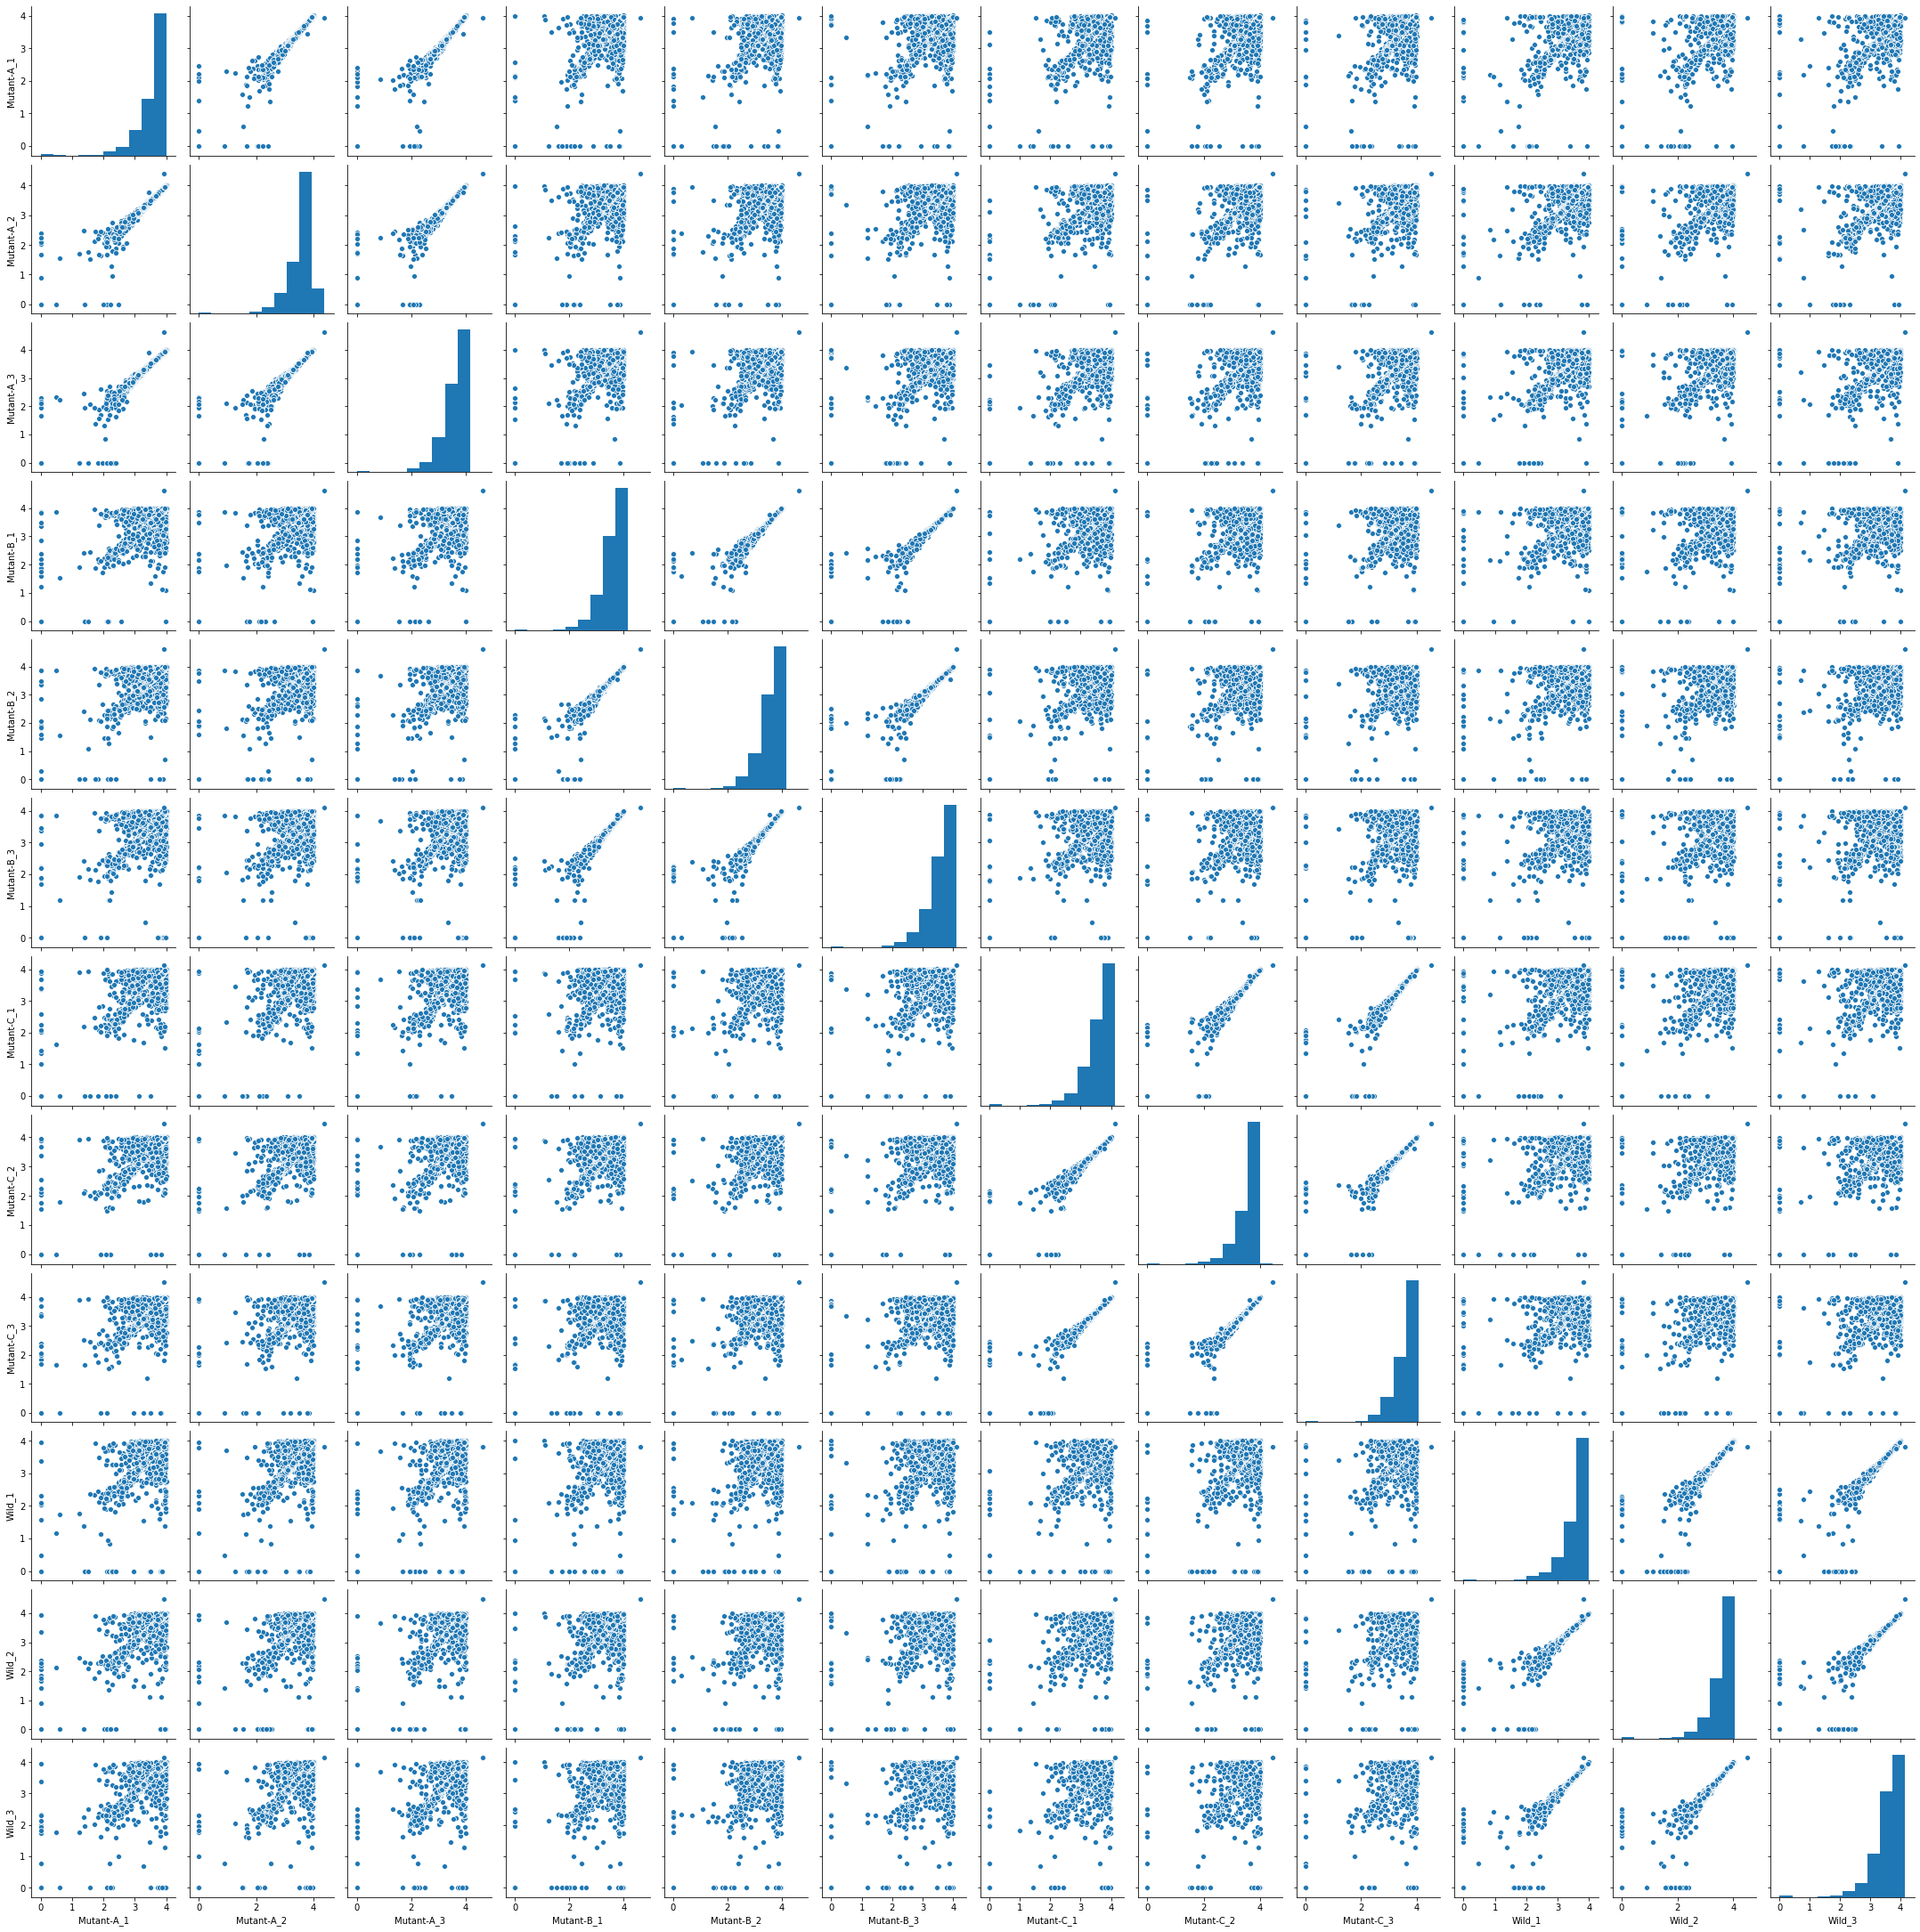

In [11]:
# +1 pour palier aux données négatives
df_mean_sup_5_log = np.log10(df_mean_sup_5+1)
sns.pairplot(df_mean_sup_5_log)

Les répétitions biologiques sont facilement identifiables. En effet, si les variations biologiques sont faibles, les gènes s'expriment de façon équivalente entre les échantillons de répétitions biologiques ce qui place les points proche de la première bissectrice.

Il y a un effet assez fort des valeurs de faible expression, ce qui est tout à fait normal. Cependant, pour l'atténuer, on peut modifier légérement les données comme suit.

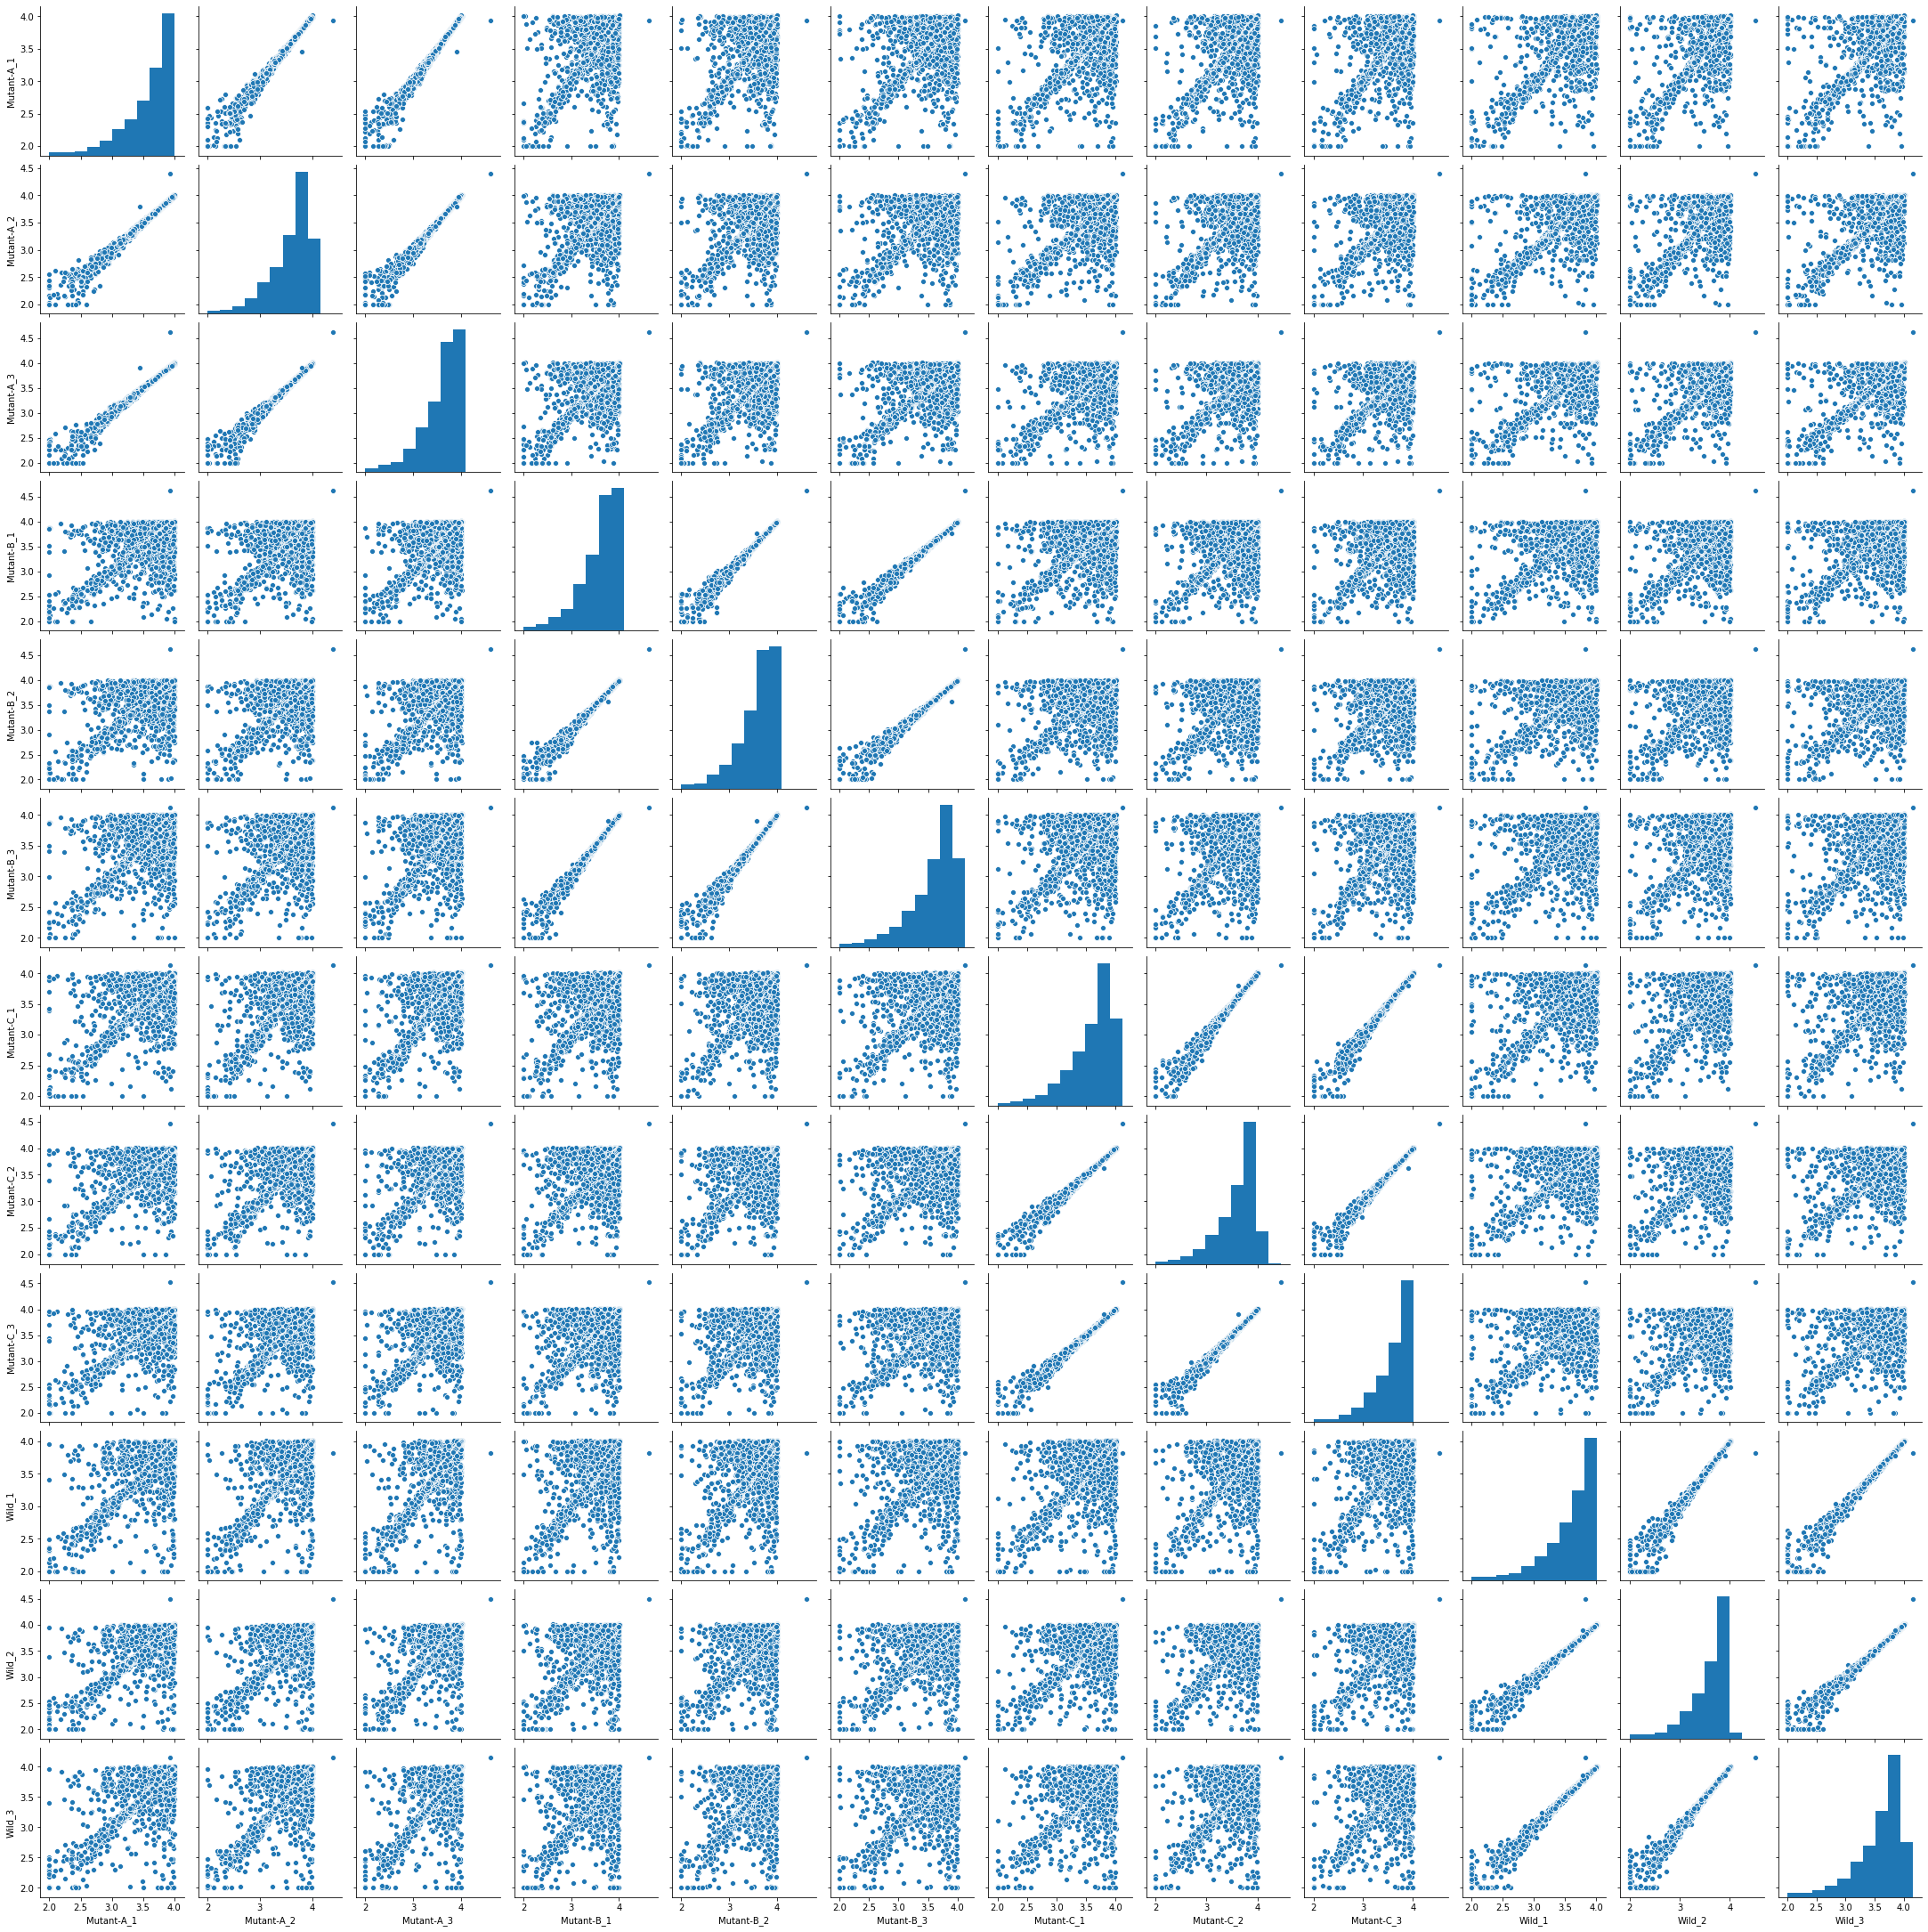

In [12]:
# +100 pour donner moins de poids aux petites valeurs
df_mean_sup_5_log = np.log10(df_mean_sup_5+100)
sns.pairplot(df_mean_sup_5_log)

**Quelques observations :**

* une forte dispersion des valeurs faibles pour les répétitions
* entre échantillons de conditions différentes, des points collés à gauche ou en bas indiquent des gènes potentiellement exprimés dans une condition et pas du tout dans une autre
* une très forte dispersion dans les valeurs fortes entre les échantillons des différentes conditions tend à laisser penser qu'il sera possible d'observer des variations intéressantes d'expression spécifiques de certaines conditions
* il y a souvent un point en haut à droite qui semble tout seul, il serai intéressant de savoir pourquoi en regardant les donnéees, quel est ce gène (peut-être un gène codant pour une partie d'un ribosome) ?